# AI4Mars Image Segmentation with U-Net

In [8]:
# Initial setup and imports
import os
import gc
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Enable GPU memory growth to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
else:
    print("No GPUs found, using CPU")

print(f"TensorFlow version: {tf.__version__}")


No GPUs found, using CPU
TensorFlow version: 2.19.0


In [9]:
# Configuration - reduced sizes to prevent memory issues
IMG_SIZE = 256  # Reduced from 512 to prevent memory issues
BATCH_SIZE = 4  # Small batch size for memory efficiency
NUM_CLASSES = 4  # 0=Soil, 1=Sand, 2=Bedrock, 3=Big Rock
BUFFER_SIZE = 1000
EPOCHS = 5  # Start with fewer epochs for testing

# Dataset paths
TRAIN_IMG_DIR = "dataset/train/images"
TRAIN_MASK_DIR = "dataset/train/masks"
TEST_IMG_DIR = "dataset/test/images"
TEST_MASK_DIR = "dataset/test/masks"

# Verify dataset existence and count files
for dir_path in [TRAIN_IMG_DIR, TRAIN_MASK_DIR, TEST_IMG_DIR, TEST_MASK_DIR]:
    if os.path.exists(dir_path):
        count = len([f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{dir_path}: {count} files")
    else:
        print(f"ERROR: {dir_path} does not exist!")

# Define color map for visualization
colormap = {
    0: (139, 69, 19),    # Brown (Soil)
    1: (255, 255, 0),    # Yellow (Sand)
    2: (128, 128, 128),  # Gray (Bedrock)
    3: (255, 0, 0),      # Red (Big Rock)
}


dataset/train/images: 12851 files
dataset/train/masks: 12851 files
dataset/test/images: 3213 files
dataset/test/masks: 3213 files


In [10]:
# CRITICAL FIX: Preprocessing function that handles mask values of 255
def preprocess_image(image_path, mask_path):
    """Memory-efficient preprocessing function using TensorFlow ops"""
    # Read image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    
    # Read mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask, tf.int32)
    mask = tf.squeeze(mask, axis=-1)  # Remove channel dimension
    
    # CRITICAL: Remap 255 values to 0 (valid class index)
    # This fixes the "label value of 255 outside valid range [0, 4)" error
    mask = tf.where(mask == 255, 0, mask)
    
    # Resize
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    mask = tf.image.resize(mask[..., tf.newaxis], [IMG_SIZE, IMG_SIZE], method='nearest')
    mask = tf.squeeze(mask, axis=-1)
    
    return image, mask

def create_dataset(image_dir, mask_dir, is_training=True):
    """Create tf.data.Dataset with efficient preprocessing"""
    # Get file paths
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg'))]
    mask_files = [f.replace('.JPG', '.png').replace('.jpg', '.png') for f in image_files]
    
    image_paths = [os.path.join(image_dir, f) for f in image_files]
    mask_paths = [os.path.join(mask_dir, f) for f in mask_files]
    
    # Verify files exist
    valid_pairs = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        if os.path.exists(img_path) and os.path.exists(mask_path):
            valid_pairs.append((img_path, mask_path))
    
    print(f"Found {len(valid_pairs)} valid image-mask pairs in {image_dir}")
    
    image_paths, mask_paths = zip(*valid_pairs)
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((list(image_paths), list(mask_paths)))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.shuffle(BUFFER_SIZE)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset


In [11]:
# Create datasets and test data loading
print("Creating training dataset...")
train_dataset = create_dataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, is_training=True)

print("Creating test dataset...")
test_dataset = create_dataset(TEST_IMG_DIR, TEST_MASK_DIR, is_training=False)

# Calculate dataset sizes
train_size = len([f for f in os.listdir(TRAIN_IMG_DIR) if f.lower().endswith(('.jpg', '.jpeg'))])
test_size = len([f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.jpg', '.jpeg'))])

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = test_size // BATCH_SIZE

print(f"Training samples: {train_size}, Steps per epoch: {steps_per_epoch}")
print(f"Test samples: {test_size}, Validation steps: {validation_steps}")

# Test data loading and verify mask values are now in valid range
print("\nTesting data loading...")
for batch_images, batch_masks in train_dataset.take(1):
    print(f"Batch shape - Images: {batch_images.shape}, Masks: {batch_masks.shape}")
    print(f"Image dtype: {batch_images.dtype}, range: [{tf.reduce_min(batch_images):.3f}, {tf.reduce_max(batch_images):.3f}]")
    print(f"Mask dtype: {batch_masks.dtype}, range: [{tf.reduce_min(batch_masks)}, {tf.reduce_max(batch_masks)}]")
    
    # Check unique mask values to ensure 255 is remapped
    unique_values = tf.unique(tf.reshape(batch_masks, [-1]))[0]
    print(f"Unique mask values in batch: {unique_values.numpy()}")
    
    if tf.reduce_max(batch_masks) >= NUM_CLASSES:
        print("ERROR: Mask values still outside valid range!")
    else:
        print("✓ All mask values are now in valid range [0, 3]")

# Clean up memory
gc.collect()
print("\nData loading test completed successfully!")


Creating training dataset...
Found 12851 valid image-mask pairs in dataset/train/images
Creating test dataset...
Found 3213 valid image-mask pairs in dataset/test/images
Training samples: 12851, Steps per epoch: 3212
Test samples: 3213, Validation steps: 803

Testing data loading...
Batch shape - Images: (4, 256, 256, 3), Masks: (4, 256, 256)
Image dtype: <dtype: 'float32'>, range: [0.002, 1.000]
Mask dtype: <dtype: 'int32'>, range: [0, 3]
Unique mask values in batch: [0 3 1 2]
✓ All mask values are now in valid range [0, 3]

Data loading test completed successfully!


In [12]:
# Create U-Net model with reduced complexity for memory efficiency
def create_unet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """Create U-Net model with reduced filter counts for memory efficiency"""
    inputs = tf.keras.Input(shape=input_shape)
    
    # Encoder (downsampling)
    c1 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D(2)(c1)
    
    c2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D(2)(c2)
    
    c3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D(2)(c3)
    
    # Bottleneck
    b = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(p3)
    b = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(b)
    
    # Decoder (upsampling)
    u1 = tf.keras.layers.UpSampling2D(2)(b)
    u1 = tf.keras.layers.concatenate([u1, c3])
    c4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(u1)
    c4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c4)
    
    u2 = tf.keras.layers.UpSampling2D(2)(c4)
    u2 = tf.keras.layers.concatenate([u2, c2])
    c5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(u2)
    c5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c5)
    
    u3 = tf.keras.layers.UpSampling2D(2)(c5)
    u3 = tf.keras.layers.concatenate([u3, c1])
    c6 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(u3)
    c6 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(c6)
    
    # Output layer
    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax')(c6)
    
    return tf.keras.Model(inputs, outputs)

# Create and compile model
model = create_unet_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model created and compiled successfully!")
print(f"Total parameters: {model.count_params():,}")


Model created and compiled successfully!
Total parameters: 1,946,980


In [17]:
# Start training with error handling
print("Starting training...")
print("=" * 50)

try:
    history = model.fit(
        train_dataset,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_data=test_dataset,
        validation_steps=validation_steps,
        verbose=1
    )
    
    print("\n🎉 Training completed successfully!")
    
except Exception as e:
    print(f"\n❌ Training failed with error: {e}")
    print("\nTroubleshooting suggestions:")
    print("1. Reduce BATCH_SIZE further (try 2 or 1)")
    print("2. Reduce IMG_SIZE further (try 128)")
    print("3. Check GPU memory: nvidia-smi")
    print("4. Restart kernel to clear memory")
    raise e


Starting training...
Epoch 1/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 1835s 571ms/step - accuracy: 0.7449 - loss: 0.5710 - val_accuracy: 0.8157 - val_loss: 0.4491
Epoch 2/10
   1/3212 ━━━━━━━━━━━━━━━━━━━━ 21:54 409ms/step - accuracy: 0.8345 - loss: 0.4179

/Users/yatharthvardan/Documents/USD/ai4mars-dataset-merged-0.1/py11/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3212/3212 ━━━━━━━━━━━━━━━━━━━━ 138s 43ms/step - accuracy: 0.8345 - loss: 0.4179 - val_accuracy: 0.8110 - val_loss: 0.4602
Epoch 3/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 1923s 598ms/step - accuracy: 0.8227 - loss: 0.4315 - val_accuracy: 0.8497 - val_loss: 0.3710
Epoch 4/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 141s 44ms/step - accuracy: 0.8908 - loss: 0.3097 - val_accuracy: 0.8497 - val_loss: 0.3712
Epoch 5/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 2012s 626ms/step - accuracy: 0.8436 - loss: 0.3843 - val_accuracy: 0.8642 - val_loss: 0.3375
Epoch 6/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 148s 46ms/step - accuracy: 0.7797 - loss: 0.4418 - val_accuracy: 0.8616 - val_loss: 0.3415
Epoch 7/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 2046s 637ms/step - accuracy: 0.8577 - loss: 0.3499 - val_accuracy: 0.8655 - val_loss: 0.3270
Epoch 8/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 150s 47ms/step - accuracy: 0.8039 - loss: 0.4304 - val_accuracy: 0.8686 - val_loss: 0.3203
Epoch 9/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 2040s 635ms/step - accuracy: 0.8

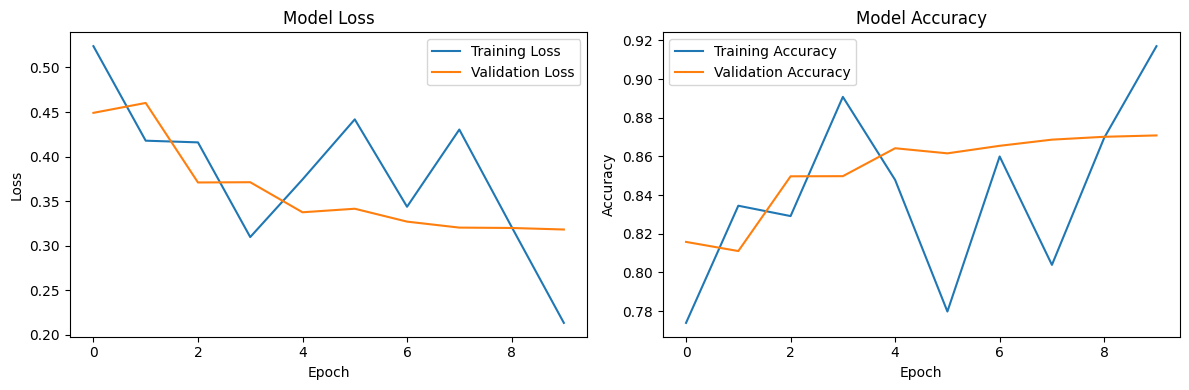

Sample predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


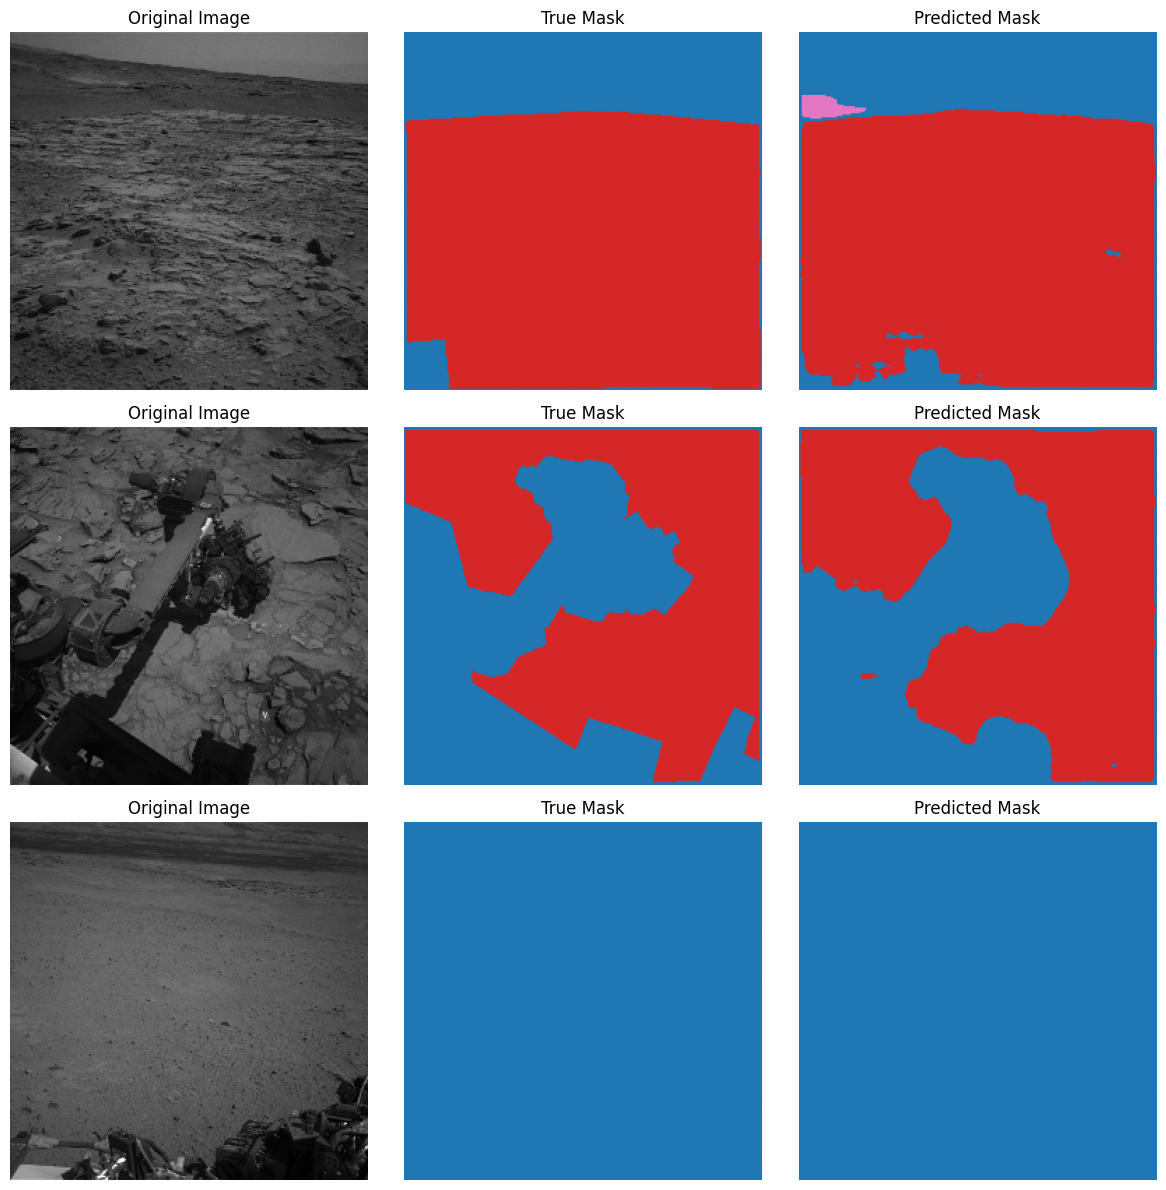

In [18]:
# Visualization and results
def visualize_sample_predictions(model, dataset, num_samples=3):
    """Visualize sample predictions"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    for i, (images, masks) in enumerate(dataset.take(num_samples)):
        # Take first image from batch
        image = images[0]
        true_mask = masks[0]
        
        # Predict
        pred_mask = model.predict(tf.expand_dims(image, 0))[0]
        pred_mask = tf.argmax(pred_mask, axis=-1)
        
        # Plot
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(true_mask, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 1].set_title('True Mask')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot training history if training succeeded
if 'history' in locals():
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Show sample predictions
    print("Sample predictions:")
    visualize_sample_predictions(model, test_dataset)



## Final metrics for the UNet Algorithm


In [20]:
print(f"Accuracy of the UNet Image segmentation model is {history.history['accuracy'][-1]}")
print(f"Loss of the UNet Image segmentation model is {history.history['loss'][-1]}")
print(f"Validation Accuracy of the UNet Image segmentation model is {history.history['val_accuracy'][-1]}")
print(f"Validation Loss of the UNet Image segmentation model is {history.history['val_loss'][-1]}")
print(f"Epochs of the UNet Image segmentation model is {history.epoch[-1]}")

Accuracy of the UNet Image segmentation model is 0.9169972538948059
Loss of the UNet Image segmentation model is 0.21335870027542114
Validation Accuracy of the UNet Image segmentation model is 0.870823085308075
Validation Loss of the UNet Image segmentation model is 0.31816577911376953
Epochs of the UNet Image segmentation model is 9


In [31]:
model.save("unet_model.keras")

1. IoU / Jaccard Index

In [37]:
import numpy as np

def compute_class_iou(y_true, y_pred, num_classes):
    iou_per_class = {}
    
    for class_id in range(2):
        # Create binary masks for current class
        true_class = (y_true == class_id)
        pred_class = (y_pred == class_id)
        
        intersection = np.logical_and(true_class, pred_class).sum()
        union = np.logical_or(true_class, pred_class).sum()
        
        iou = intersection / union if union != 0 else 0.0
        iou_per_class[f"class_{class_id}"] = round(iou, 4)
    
    mean_iou = round(np.mean(list(iou_per_class.values())), 4)
    return iou_per_class, mean_iou


In [39]:
# Assuming your model outputs softmax over classes:
MEAN_IOU = []

for i, (image, mask) in enumerate(test_dataset):
    image = image[0]
    true_mask = mask[0]
        
    # Predict
    pred_mask = model.predict(tf.expand_dims(image, 0))[0]
    pred_mask = tf.argmax(pred_mask, axis=-1)        # shape: (H, W)
    
    true_class_mask = true_mask.numpy().squeeze()              # shape: (H, W), same format
    num_classes = pred_mask.shape[-1]
    per_class_iou, mean_iou = compute_class_iou(true_class_mask, pred_mask, num_classes)
    MEAN_IOU.append(mean_iou)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

In [40]:
print(f"Mean IOU of the model is {np.mean(MEAN_IOU)}")

Mean IOU of the model is 0.6124150497512438


## SegNet algorithm

In [15]:
segnet_model = segnet(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=4)
segnet_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
